<h1><center> TP3: NN and CNN with ```pytorch``` </center></h1>

The deadline for report submission is Tuesday, December 22th 2020.

Note: the goal of this TP is to become familiar with 'Pythor' and to understand how to implement Neural Nets with Pyhtor.

We first list the basic function in Pythor and consider a very simple example to understand how Grandient Descent can be implemented. Then we illustrate how set the architecture of neural nets and run it on MNIST dataset. Lastly, we provide an implementation of CNN.

As a homework, we propose you implement logistic regression as a neural net and to also to add dropout in CNN.

In [1]:
conda install pytorch torchvision torchaudio cudatoolkit=11.0 -c pytorch

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - cudatoolkit=11.0

Current channels:

  - https://conda.anaconda.org/pytorch/osx-64
  - https://conda.anaconda.org/pytorch/noarch
  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install -c conda-forge tqdm

Solving environment: done

## Package Plan ##

  environment location: /usr/local/anaconda3

  added / updated specs:
    - tqdm


The following packages will be SUPERSEDED by a higher-priority channel:

  conda               pkgs/main::conda-4.9.2-py38hecd8cb5_0 --> conda-forge::conda-4.9.2-py38h50d1736_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm

Pytorch operates with tensors instead of numpy arrays. Almost everything you can do with numpy arrays can be acomplished with pytorch tensors.

In [2]:
x = torch.rand(3, 3) # random tensor of size 3 by 3
print(x)

tensor([[0.3592, 0.3340, 0.9200],
        [0.8460, 0.8652, 0.5445],
        [0.9970, 0.0852, 0.4091]])


In [3]:
# We can operate with pytorch tensors pretty much in the same manner as with numpy arrays
x = torch.ones(3,3)
y = torch.ones(3,3) * 4
z = x + y
print(f'This is the result of:\n {x}\n +\n {y} \n = \n {z}')

This is the result of:
 tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
 +
 tensor([[4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.]]) 
 = 
 tensor([[5., 5., 5.],
        [5., 5., 5.],
        [5., 5., 5.]])


In [4]:
# again we can operate with tensor indexing as if it was a numpy one

x = torch.ones(3,3) * 5
y = x[-1, :2]
print(f'From \n {x} we can look at the last column and 2 rows \n {y}')



From 
 tensor([[5., 5., 5.],
        [5., 5., 5.],
        [5., 5., 5.]]) we can look at the last column and 2 rows 
 tensor([5., 5.])


**Example**

As you know, a lot of ML algorithms can be stated as optimization problems.
Let us consider a toy example: imagine that our data is $x = (1, \ldots, 1)^\top \in \mathbb{R}^{5}$ is a vector composed of all ones and a label $y = 1$. We would like to find a weight vector $w \in \mathbb{R}^{5}$ such that the loss function $L(w) = (y - x^\top w)^2$ is minimized.

Of course, this is a simple least squares on a single observation $(x, y)$ and we can compute the result analytically. But it is a good example to understand what pytorch has to offer.

If we are too lazy to compute the analytic expression, we can run the Gradient Descent, which starts from $w_0 = (0, \ldots, 0)^\top$ and proceeds as

$$w_k = w_{k - 1} - \eta \nabla L(w_{k - 1}).$$

So the only thing that we need to know is the gradient of the loss function $L$ evaluated at the point $w_{k - 1}$.
Here how it is done in pytorch.

In [5]:
# Input data
y = torch.ones(1, 1)
x = torch.ones(1, 5)

# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these tensors during the backward pass.
w = torch.zeros(5, 1, requires_grad=True) # setting w_0 = (0, ..., 0)^T

y_pred = x.mm(w) # inner product of w and x 

loss = (y - y_pred).pow(2) # squared loss


# Use autograd to compute the backward pass. This call will compute the
# gradient of loss with respect to all tensors with requires_grad=True.
# After this call w.grad will be a tensor holding the gradient
# of the loss with respect to w.
loss.backward()

print(w.grad) # Print the gradient

tensor([[-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.]])


**Question.** Assuming that $w_0 = (0, \ldots, 0)^\top$ compute on paper $\nabla L(w_0)$. Do not include the answer to this question into the report. Just make sure you understant what is going on here.

Once you made sure that ```w.grad``` indeed stores the value of $\nabla L(w_0)$. We can implement the Gradient Descent algorithm with only few lines of code!

In [6]:
# Input data
y = torch.ones(1, 1)
x = torch.ones(1, 5)

w = torch.zeros(5, 1, requires_grad=True) # Initialization: w_0 = (0, ..., 0)^T

lr = .01 # Learning rate a.k.a. the step size
max_iter = 150

for k in range(max_iter):
    loss = (y - x.mm(w)).pow(2) # forward pass
    
        
    loss.backward() # the backward pass
    
    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        w -= lr * w.grad # gradient step
        w.grad.zero_() # after performing operation with gradient we need to erase it
    
    if k % 10 == 9:
        print(f'Iteration {k + 1}/{max_iter}, Current loss: {loss.item()}')
        
print(f'Final result: {w}')

Iteration 10/150, Current loss: 0.150094673037529
Iteration 20/150, Current loss: 0.018248017877340317
Iteration 30/150, Current loss: 0.002218528650701046
Iteration 40/150, Current loss: 0.00026972233899869025
Iteration 50/150, Current loss: 3.279230440966785e-05
Iteration 60/150, Current loss: 3.986556748714065e-06
Iteration 70/150, Current loss: 4.846697265747935e-07
Iteration 80/150, Current loss: 5.8908199207508005e-08
Iteration 90/150, Current loss: 7.173785121494802e-09
Iteration 100/150, Current loss: 8.74024408403784e-10
Iteration 110/150, Current loss: 1.0756195933936397e-10
Iteration 120/150, Current loss: 1.3219647598816664e-11
Iteration 130/150, Current loss: 1.566746732351021e-12
Iteration 140/150, Current loss: 1.7408297026122455e-13
Iteration 150/150, Current loss: 1.2789769243681803e-13
Final result: tensor([[0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000]], requires_grad=True)


**Question:** Solve the problem $\min_{w \in \mathbb{R}^5}\, (1 - x^\top w)^2$ with $x = (1, \ldots, 1)^\top \in \mathbb{R}^5$ analytically and compare to the result of the Gradient Descent.

**Question:** Recalling the theory of numerical optimization, what is the learning rate ```lr``` that we need to set sto ensure the fastest convergence?
 
**Question:** Explain the connection of ```loss.backward()``` and the backpropagation for feedforward neural nets.


# Multi layer perceptron

Below we will build our neural net. Recall that MNIST is composed of images of size $28 \times 28$, hence the dimenison of the input is $784$. We have $10$ classes, so the dimension of the output is $10$.

In between we will insert $2$ hidden layers and use ReLU as our non-linearity (activation function).
The first hidden layer is composed of $128$ neurons and the second one of $64$ neurons.

We will not use GPU nor we will consider complicated neural nets in this TP. The goal is to introduce you to the basics without going into too complicated architechtures.

In [2]:
class SimpleFeedForward(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128, 64],
                 output_size=10):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]), 
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], output_size)
        )
             
    def forward(self, x):
        x = x.reshape(-1, input_size)
        x = self.classifier(x)
        return x

Once we defined our neural net we need to train it.
The training is going to be performed via Stochastic Gradient Descent evaluated on a mini batch of the data.
That is, on the foward stage we will use not a single data point but several ones. In this case we set the size of mini batch equal to $32$.

Actually, size of the mini batch, learning rate sizes of hidden layers are all considered as hyperparameters that can be finely tuned (some people even tune random seed, which is absolutely ridiculous). We will not talk about the hypeparameter tuning in this TP, to learn more have a look at https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html .


**Important:** We do not require you to perform complicated hyperparameter tuning. This part is beyond the course. However, it is important that you can clearly write an architechture of a nerual net that you consider.


In [3]:
# Training consists of gradient steps over mini batch of data
def train(model, trainloader, loss, optimizer, epoch, num_epochs):
    # We enter train mode. This is useless for the linear model
    # but is important for layers such as dropout, batchnorm, ...
    model.train()
    
    loop = tqdm(trainloader)
    loop.set_description(f'Training Epoch [{epoch + 1}/{num_epochs}]')
    
    # We iterate over the mini batches of our data
    for inputs, targets in loop:
    
        # Erase any previously stored gradient
        optimizer.zero_grad()
        
        
        outputs = net(inputs) # Forwards stage (prediction with current weights)
        loss = criterion(outputs, targets) # loss evaluation
        
        loss.backward() # Back propagation (evaluate gradients) 
        
        
        # Making gradient step on the batch (this function takes care of the gradient step for us)
        optimizer.step() 
        
def validation(model, valloader, loss):
    # Do not compute gradient, since we do not need it for validation step
    with torch.no_grad():
        # We enter evaluation mode.
        model.eval()
        
        total = 0 # keep track of currently used samples
        running_loss = 0.0 # accumulated loss without averagind
        accuracy = 0.0 # accumulated accuracy without averagind (number of correct predictions)
        
        loop = tqdm(valloader) # This is for the progress bar
        loop.set_description('Validation in progress')
        
        
        # We again iterate over the batches of validation data. batch_size does not play any role here
        for inputs, targets in loop:
            # Run samples through our net
            outputs = model(inputs)

            # Total number of used samples
            total += inputs.shape[0]

            # Multiply loss by the batch size to erase averagind on the batch
            running_loss += inputs.shape[0] * loss(outputs, targets).item()
            
            # how many correct predictions
            accuracy += (outputs.argmax(dim=1) == targets).sum().item()
            
            # set nice progress meassage
            loop.set_postfix(val_loss=(running_loss / total), val_acc=(accuracy / total))
        return running_loss / total, accuracy / total

We use again the MNIST dataset. This time we will use the official train/test split!

In [4]:
# We download the oficial MNIST train set
all_train = datasets.MNIST('data/',
                           download=True,
                           train=True,
                           transform=transforms.ToTensor())

# We split the whole train set in two parts:
# the one that we actually use for training
# and the one that we use for validation
batch_size = 32 # size of the mini batch
num_train = int(0.8 * len(all_train))

trainset, valset = torch.utils.data.random_split(all_train, [num_train, len(all_train) - num_train])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Dimensions of the inputs are torch.Size([32, 1, 28, 28])
The number on the image is: 1


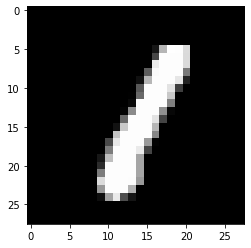

In [5]:
# we can iterate over trainloader in the following way
for inputs, targets in trainloader:
    print(f'Dimensions of the inputs are {inputs.shape}')
    plt.imshow(inputs[0][0], cmap='gray', interpolation='none')
    print(f'The number on the image is: {targets[0]}')
    break

The shape of ```inputs``` is $(32, 1, 28, 28)$. The first dimension indicates the size of the mini batch and is controlled by parameter ```batch_size```, the last two parameters are the 2D dimensions of the image and are equal to $28 \times 28$ in case of the MNIST data. The lonely $1$, staying in the second dimension essentialy reflects the fact that the images are black and white. For instance, if MNIST were colored (there are variants of colored MNIST actually), then we would need $3$ (in case of RGB) colors to represent an image, thus $1$ would be replaed by $3$. 

**Question:** Run the above block several times. Is it plotting the same number all the time? If not, why?

In [6]:
# Net + training parameters
num_epochs = 2 # how many passes over the whole train data
input_size = 784 # flattened size of the image
hidden_sizes = [128, 64] # sizes of hidden layers
output_size = 10 # how many labels we have
lr = 0.001 # learning rate
momentum = 0.9 # momentum

In [7]:
# initializing our model/loss/optimizer
net = SimpleFeedForward(input_size, hidden_sizes, output_size) # Our neural net
criterion = nn.CrossEntropyLoss() # Loss function to be optimized
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum) # Optimization algorithm

In [8]:
# num_epochs indicates the number of passes over the data
for epoch in range(num_epochs):
    
    # makes one pass over the train data and updates weights
    train(net, trainloader, criterion, optimizer, epoch, num_epochs)

    # makes one pass over validation data and provides validation statistics
    val_loss, val_acc = validation(net, valloader, criterion)


In [9]:
# Let us evaluate our net on the test set that we have never seen!
testset = datasets.MNIST('data/',
                         download=True,
                         train=False,
                         transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

test_loss, test_acc = validation(net, testloader, criterion)
print(f'Test accuracy: {test_acc} | Test loss: {test_loss}')

Using downloaded and verified file: data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!



Test accuracy: 0.8973 | Test loss: 0.34896888802051546


# Problem 1: Logistic regression via pytorch

Using above code as an example implement multinomial logistic regression and train it on the same data.
For your report include:
1. Mathematical description of logistic regression
2. Mathematical description of optimization algorithm that you use
3. High level idea of how to implement logisitic regression with pytorch
4. Report classification accuracy on test data.

In [10]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(input_size, output_size),
            torch.nn.Softmax(),
        )
                            

    def forward(self, x):
        x = x.reshape(-1, input_size)
        x = self.classifier(x)
        return x

In [11]:
# Training consists of gradient steps over mini batch of data
def train(model, trainloader, loss, optimizer, epoch, num_epochs):
    model.train()
    loop = tqdm(trainloader)
    loop.set_description(f'Training Epoch [{epoch + 1}/{num_epochs}]')
    
    # We iterate over the mini batches of our data
    for inputs, targets in loop:
    
        # Erase any previously stored gradient
        optimizer.zero_grad()
        
        
        outputs = net(inputs) # Forwards stage (prediction with current weights)
        loss = criterion(outputs, targets) # loss evaluation
        
        loss.backward() # Back propagation (evaluate gradients) 
        
        
        # Making gradient step on the batch (this function takes care of the gradient step for us)
        optimizer.step() 
        
def validation(model, valloader, loss):
    # Do not compute gradient, since we do not need it for validation step
    with torch.no_grad():
        # We enter evaluation mode.
        model.eval()
        
        total = 0 # keep track of currently used samples
        running_loss = 0.0 # accumulated loss without averaging
        accuracy = 0.0 # accumulated accuracy without averaging (number of correct predictions)
        
        loop = tqdm(valloader) # This is for the progress bar
        loop.set_description('Validation in progress')
        
        
        # We again iterate over the batches of validation data. batch_size does not play any role here
        for inputs, targets in loop:
            # Run samples through our net
            outputs = model(inputs)

            # Total number of used samples
            total += inputs.shape[0]

            # Multiply loss by the batch size to erase averagind on the batch
            running_loss += inputs.shape[0] * loss(outputs, targets).item()
            
            # how many correct predictions
            accuracy += (outputs.argmax(dim=1) == targets).sum().item()
            
            # set nice progress meassage
            loop.set_postfix(val_loss=(running_loss / total), val_acc=(accuracy / total))
        return running_loss / total, accuracy / total

In [12]:
# We download the oficial MNIST train set
all_train = datasets.MNIST('data/',
                           download=True,
                           train=True,
                           transform=transforms.ToTensor())

# We split the whole train set in two parts:
# the one that we actually use for training
# and the one that we use for validation
batch_size = 32 # size of the mini batch
num_train = int(0.8 * len(all_train))

trainset, valset = torch.utils.data.random_split(all_train, [num_train, len(all_train) - num_train])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

Using downloaded and verified file: data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [13]:
# Net + training parameters
num_epochs = 2 # how many passes over the whole train data
input_size = 784 # flattened size of the image

output_size = 10 # how many labels we have
lr = 0.01 # learning rate
momentum = 0.9 # momentum

In [14]:
# initializing our model/loss/optimizer
net = LogisticRegression(input_size, output_size) # Our neural net
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum = momentum) # Optimization algorithm

In [15]:
# num_epochs indicates the number of passes over the data
for epoch in range(num_epochs):
    
    # makes one pass over the train data and updates weights
    train(net, trainloader, criterion, optimizer, epoch, num_epochs)

    # makes one pass over validation data and provides validation statistics
    val_loss, val_acc = validation(net, valloader, criterion)

/usr/local/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [16]:
# Let us evaluate our net on the test set that we have never seen!
testset = datasets.MNIST('data/',
                         download=True,
                         train=False,
                         transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

test_loss, test_acc = validation(net, testloader, criterion)
print(f'Test accuracy: {test_acc} | Test loss: {test_loss}')

Using downloaded and verified file: data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!



Test accuracy: 0.9015 | Test loss: 1.5949760681152343


# Elements of CNN: ```nn.Conv2d``` and ```MaxPool2d```

Read this before starting: https://ttic.uchicago.edu/~shubhendu/Pages/Files/Lecture7_flat.pdf

**Understanding the convolutional layer in pytorch**

Once we instanciate ```nn.Conv2d(1, 1, kernel_size=2, stride=[1, 1], padding=0)``` it has a parameter ```weight``` which precisely describes the kernel used for our convolution. In the beginning it is initialized randomly, and our goal is to eventually learn its weights (as usual via backpropagation!).
Before building our first CNN let us have a look at the kernel and what it does.

In [15]:
# 1 input channel (first 1 in nn.Conv2d)
# 1 output channel (second 1 in nn.Conv2d)
# 2x2 kernel (kernel_size=2)
# the kernel slides by one step in (x, y) direction (stride=[1, 1])
# we do not augment the picture with white borders (padding=0)
conv = nn.Conv2d(1, 1, kernel_size=2, stride=[1, 1], padding=0) 
# Get kernel value.
weight = conv.weight.data.numpy()
weight

array([[[[ 0.07415688, -0.30996   ],
         [-0.20658672, -0.36997014]]]], dtype=float32)

**Visualization.** We will plot the initial image, the kernel, and the resulting image. In order to understand what is going on, the resulting image will be computed in two ways. First of all it will be computed by using ```conv1(image)```. Secondly, we will manually apply the sliding kernel to each $2\times 2$ window.

Text(0.5, 1.0, 'By hand')

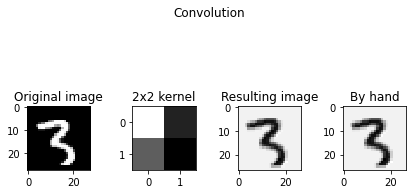

In [16]:
# take one image
image, _ = next(iter(trainloader))


fig, axs = plt.subplots(1, 4)
fig.tight_layout()
fig.suptitle('Convolution')

# plot the image
axs[0].imshow(image[0][0], cmap='gray', interpolation='none')
axs[0].set_title('Original image')

# plot the kernel
axs[1].imshow(weight[0][0], cmap='gray', interpolation='none')
axs[1].set_title('2x2 kernel')

# plot resulting image
axs[2].imshow(conv(image)[0][0].detach().numpy(), cmap='gray', interpolation='none')
axs[2].set_title('Resulting image')

# Making the same by hands
# IMPORTANT: we strongly suggest to understand the below code
np_image = image[0][0].data.numpy() # get numpy image
image_convolved = np.zeros((27, 27)) # here we store our result
for i in range(27):
    for j in range(27):
        image_convolved[i, j] = np.sum(np_image[i:i+2, j:j+2] * weight) # apply the kernel for each 2x2 window
        
axs[3].imshow(image_convolved, cmap='gray', interpolation='none')
axs[3].set_title('By hand')


**Problem.** Provide 'by hand' implementation of the following kernel 

Text(0.5, 1.0, 'By hand')

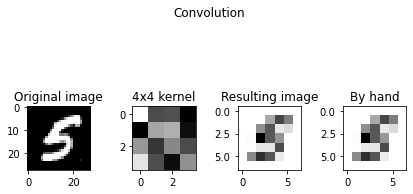

In [17]:
# 1 input channel (first 1 in nn.Conv2d)
# 1 output channel (second 1 in nn.Conv2d)
# 4x4 kernel (kernel_size=4)
# the kernel slides by 3 step in (x, y) direction (stride=[4, 4])
# we do not augment the picture with white borders (padding=0)
conv = nn.Conv2d(1, 1, kernel_size=4, stride=[4, 4], padding=0) 
# Get kernel value.
weight = conv.weight.data.numpy()

# take one image
image, _ = next(iter(trainloader))


fig, axs = plt.subplots(1, 4)
fig.tight_layout()
fig.suptitle('Convolution')

# plot the image
axs[0].imshow(image[0][0], cmap='gray', interpolation='none')
axs[0].set_title('Original image')

# plot the kernel
axs[1].imshow(weight[0][0], cmap='gray', interpolation='none')
axs[1].set_title('4x4 kernel')

# plot resulting image
axs[2].imshow(conv(image)[0][0].detach().numpy(), cmap='gray', interpolation='none')
axs[2].set_title('Resulting image')

# Making the same by hands
# PROBLEM: FILL IN THIS PART.
np_image = image[0][0].data.numpy() # get numpy image
image_conv = np.zeros((7,7))
for i in range(7):
    for j in range(7):
        image_conv[i, j]=np.sum(np_image[(4*i):(4*i+4), (4*j):(4*j+4)] * weight)

axs[3].imshow(image_conv, cmap='gray', interpolation='none')
axs[3].set_title('By hand')

**Understanding the pooling layer in pytorch**

Max pooling is what often used in practice, it amounts to picking only the largest value of a pixel in a given window. In pytorch it is done via ```MaxPool2d(kernel_size=k, stride=s)```, which has two parameters: kernel size and the stride. Note that there are no weights to learn here, so this layer is simply fixed.

Text(0.5, 1.0, 'By hand')

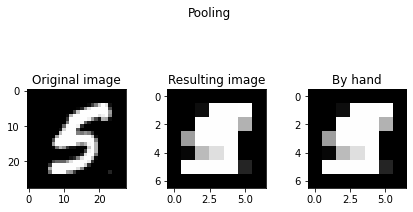

In [18]:
# kernel_size -- size of the max pool window
pool = nn.MaxPool2d(kernel_size=4, stride=[4,4])

fig, axs = plt.subplots(1, 3)
fig.tight_layout()
fig.suptitle('Pooling')

# plot the image
axs[0].imshow(image[0][0], cmap='gray', interpolation='none')
axs[0].set_title('Original image')


# plot resulting image
axs[1].imshow(pool(image)[0][0].detach().numpy(), cmap='gray', interpolation='none')
axs[1].set_title('Resulting image')

# Making the same by hands
# IMPORTANT: we strongly suggest to understand the below code
np_image = image[0][0].data.numpy() # get numpy image
image_pooled = np.zeros((7, 7)) # here we store our result
for i in range(0, 27, 4):
    for j in range(0, 27, 4):
        image_pooled[int(i / 4), int(j / 4)] = np.max(np_image[i:i+4, j:j+4]) # max pooling
        
axs[2].imshow(image_pooled, cmap='gray', interpolation='none')
axs[2].set_title('By hand')

# Bulding a simple ConvNet

In [19]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=[1, 1], padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.classifier = nn.Sequential(
            nn.Linear(14 * 14 * 8, 500),
            nn.ReLU(),
            nn.Linear(500, 10),
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.classifier(out)
        return out

Note that the first layer is ```nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)```, the parameters here are chosen in such a way that the size of each output channel remains as $28 \times 28$. Indeed, setting ```padding = 2``` we augmented our initial image to $32 \times 32$, then we slide a kernel of size $5 \times 5$ by $1$ in both $(x, y)$ directions which result in a $28 \times 28$ output image (and $8$ channels).

In general the formula for square images and squared kernels is
$$
    S_{out} = \frac{S_{in} - S_{kernel} + 2S_{padding}}{S_{stride}} + 1
$$

In our case it is

$$
    S_{out} = \frac{28 - 5 + 4}{1} + 1 = 28
$$

Then the output of ```nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2)``` goes into ```nn.ReLU()``` our favorite non-linearity and eventually into the pooling layer ```nn.MaxPool2d(kernel_size=2, stride=2)```.
The ```nn.ReLU()``` doe not affect the size, hence ```nn.MaxPool2d(kernel_size=2, stride=2)``` receives $8$ channels of $28 \times 28$ images as computed above.

```nn.MaxPool2d(kernel_size=2, stride=2)``` will be applied to each single channel, with ```kernel_size=2, stride=2``` meaning that the output will still have $8$ channels but the images will be halfed in both $(x, y)$ directions. Hence the output of ```nn.MaxPool2d(kernel_size=2, stride=2)``` has $8$ channels with $14 \times 14$ images.

After all this, we will flatten our features and put the into simple ```nn.Linear(14 * 14 * 8, 500)```, where the input size is precisely the output size of ```nn.MaxPool2d(kernel_size=2, stride=2)```, and $500$ stands for the output size of this linear layer.
Finally, we apply our favorite nonlinearity to ```nn.Linear(14 * 14 * 8, 500)``` followed by fully connected linear layer ```nn.Linear(500, 10)``` to match the dimension of $10$ classes.

In [20]:
net = ConvNet()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

for epoch in range(num_epochs):
    
    # makes one pass over the train data and updates weights
    train(net, trainloader, criterion, optimizer, epoch, num_epochs)

    # makes one pass over validation data and provides validation statistics
    val_loss, val_acc = validation(net, valloader, criterion)

In [21]:
test_loss, test_acc = validation(net, testloader, criterion)
print(f'Test accuracy: {test_acc} | Test loss: {test_loss}')


Test accuracy: 0.9796 | Test loss: 0.06116014178171754


As you see the result here is much better, than in the simple multilayer perceptron. But note, we have actualy trained muuuuuch more parameters here and, at least on my computer, it takes considerably more time.

Here you can see the summary of current state of the art results on MNIST: https://www.kaggle.com/c/digit-recognizer/discussion/61480

As you see our score barely beats a carefully built random forest or **kNN**! To get extra $0.01$ requires much more fine tuning, which is of course is not the goal here.

# Problem 2: Dropout

Modify the code for ConvNet and insert Dropout layer (whereever you want).

Include in your report:
1. High level description of the dropout
2. High level description of your architechture

In [29]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=[1, 1], padding=2),
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.classifier = nn.Sequential(
            nn.Linear(14 * 14 * 8, 500),
            nn.ReLU(),
            nn.Linear(500, 10),
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.classifier(out)
        return out

In [30]:
net = ConvNet()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

for epoch in range(num_epochs):
    
    # makes one pass over the train data and updates weights
    train(net, trainloader, criterion, optimizer, epoch, num_epochs)

    # makes one pass over validation data and provides validation statistics
    val_loss, val_acc = validation(net, valloader, criterion)

In [31]:
test_loss, test_acc = validation(net, testloader, criterion)
print(f'Test accuracy: {test_acc} | Test loss: {test_loss}')


Test accuracy: 0.9753 | Test loss: 0.07293129253424704


# Conclusion

After the succesful completion of this TP, we expect you to be able to understand the architectures of NN, CNN.
For instance, have a look at the famous AlexNet https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py and see if you can understand its architechture.